## 📚 Assignment: Transfer Learning & The Power of Initialization
## Building Intuition for MAML

**Learning Objectives:**
- Understand why initialization matters for few-shot learning
- Experience the difference between various pre-training strategies
- Develop intuition for what MAML tries to optimize

**Advice on using LLM's**

---


Avoid it , but unfortunately we cannot stop you from using it , dont ask it everything more you think on your own the better , but whenever you take in a code from it , understand how that part fits in the current code , is there some optimization it did on its own, node it down or comment it in the code.

In [1]:
!pip install -q torch torchvision matplotlib numpy

#Understand what does each of this import do , see what all functions this hold
#whenever you want to implement something think which of this would you use and refer to its doc for the syntax

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import random

print("✅ Setup complete!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

✅ Setup complete!
PyTorch version: 2.9.0+cpu
CUDA available: False
Using device: cpu


## 📊 Part A: Dataset Preparation

We'll use **MNIST** for simplicity (or you can use Omniglot if you prefer).

**Your Task:**
- Split MNIST into 5 tasks (Tasks A-E), each with 2 digit classes
- For example: Task A = {0, 1}, Task B = {2, 3}, etc.

In [14]:
# Importing required libraries (already installed and imported earlier)
import torch
import torchvision
import torchvision.transforms as transforms
from collections import defaultdict
import random

# MNIST images are PIL images of size 28x28 (grayscale).
# Neural networks work with tensors, not PIL images.
# transforms.ToTensor():
#   - Converts image to torch.Tensor
#   - Scales pixel values from [0, 255] → [0.0, 1.0]
transform = transforms.Compose([
    transforms.ToTensor()
])
# train=True  → training split
# train=False → test split
# download=True → downloads dataset if not present locally
# transform=transform → applies preprocessing defined above
train_dataset = torchvision.datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

test_dataset = torchvision.datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

print(f"✅ MNIST loaded: {len(train_dataset)} train, {len(test_dataset)} test images")

# We split the 10 MNIST digit classes into 5 disjoint tasks.
# Each task contains exactly 2 digit classes.
# This is a standard task-based / meta-learning setup.
task_definitions = {
    'A': [0, 1],
    'B': [2, 3],
    'C': [4, 5],
    'D': [6, 7],
    'E': [8, 9]
}

def create_task_datasets(dataset, task_classes, n_train=15, n_support=5, n_query=10):
    """
    Returns task-relative labels:
    - For binary tasks → labels {0,1}
    - For 10-class task → labels {0..9}
    """

    from collections import defaultdict
    import random

    class_to_samples = defaultdict(list)

    # Collect samples belonging to task_classes
    for image, label in dataset:
        if label in task_classes:
            # Convert MNIST label → task-relative label
            relative_label = task_classes.index(label)
            class_to_samples[label].append((image, relative_label))

    train_data, support_data, query_data = [], [], []

    for cls in task_classes:
        random.shuffle(class_to_samples[cls])

        train_data.extend(class_to_samples[cls][:n_train])
        support_data.extend(class_to_samples[cls][n_train:n_train+n_support])
        query_data.extend(class_to_samples[cls][n_train+n_support:
                                                 n_train+n_support+n_query])

    return train_data, support_data, query_data


print(f"Task A - Train: {len(train_A)}, Support: {len(support_A)}, Query: {len(query_A)}")


✅ MNIST loaded: 60000 train, 10000 test images
Task A - Train: 30, Support: 10, Query: 20


Part A (continued): **Build Your Model**

**TODO:** Design a simple CNN for digit classification

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# We inherit from nn.Module, which is the base class
# for all neural network models in PyTorch.
class SimpleCNN(nn.Module):

    def __init__(self):
        """
        Constructor: define all layers of the network here.
        This method runs once when the model is created.
        """
        super(SimpleCNN, self).__init__()

        # ----------------------------
        # Convolutional Layer 1
        # ----------------------------
        # Input: 1 channel (grayscale MNIST image)
        # Output: 16 feature maps
        # Kernel size: 3x3
        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=16,
            kernel_size=3,
            padding=1
        )

        # ----------------------------
        # Convolutional Layer 2
        # ----------------------------
        # Input: 16 channels
        # Output: 32 feature maps
        self.conv2 = nn.Conv2d(
            in_channels=16,
            out_channels=32,
            kernel_size=3,
            padding=1
        )

        # ----------------------------
        # Max Pooling Layer
        # ----------------------------
        # Reduces spatial size by factor of 2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # ----------------------------
        # Fully Connected Layers
        # ----------------------------
        # After two poolings, image size:
        # 28x28 → 14x14 → 7x7
        # Channels = 32
        self.fc1 = nn.Linear(32 * 7 * 7, 128)

        # Final classification layer
        # Output = number of classes (binary or multi-class)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        """
        Forward pass: defines how data flows through the network.
        This runs every time we pass input to the model.
        """

        # ----------------------------
        # First Conv Block
        # ----------------------------
        x = self.conv1(x)      # Convolution
        x = F.relu(x)          # Non-linearity
        x = self.pool(x)       # Downsampling

        # ----------------------------
        # Second Conv Block
        # ----------------------------
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)

        # ----------------------------
        # Flatten the tensor
        # ----------------------------
        # Converts 4D tensor → 2D (batch_size, features)
        x = x.view(x.size(0), -1)

        # ----------------------------
        # Fully Connected Layers
        # ----------------------------
        x = self.fc1(x)
        x = F.relu(x)

        x = self.fc2(x)  # Final logits (no softmax here)

        return x

Now since the model is ready we decide how do we want to train it :

First Do normal classification on large dataset of Task A - 0 & 1.

The we will do fine tuning

1.   Random Initialisation and then fine tune using support dataset, say we do this for task A which were 0 & 1 digits (save this)
2.   Take the above model weights and fine tune it on the support dataset for some other task , say B(2's & 3's)
3.   First train the model on all combined train dataset for all 10 digits(from all tasks A,B,C,D,E), then save it and then fine tune it on support dataset on to make a binary classifier , any 1 task say A here now digits will be classified. 0 class->0 digit , 1->1.

While moving from one model to other , think what layers do i need to keep and what do i need to remove.



In [33]:
import torch
import torch.nn as nn
import torch.optim as optim

model_A = SimpleCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_A.parameters(), lr=1e-3)

epochs = 5
loss_method1 = []

for epoch in range(epochs):
    model_A.train()
    epoch_loss = 0.0

    for image, label in train_A:
        image = image.unsqueeze(0).to(device)
        label = torch.tensor([label]).to(device)  # already 0/1

        output = model_A(image)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    loss_method1.append(epoch_loss)

torch.save(model_A.state_dict(), "model_task_A.pth")


In [34]:
model_A_support = SimpleCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_A_support.parameters(), lr=1e-3)

epochs = 5
loss_method2_1 = []

for epoch in range(epochs):
    model_A_support.train()
    epoch_loss = 0.0

    for image, label in support_A:
        image = image.unsqueeze(0).to(device)
        label = torch.tensor([label]).to(device)

        output = model_A_support(image)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    loss_method2_1.append(epoch_loss)


In [35]:
model_B = SimpleCNN().to(device)
model_B.load_state_dict(torch.load("model_task_A.pth"))

# Replace classifier for new binary task
model_B.fc2 = nn.Linear(128, 2).to(device)


In [36]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_B.parameters(), lr=1e-4)

epochs = 5
loss_method2_2 = []

for epoch in range(epochs):
    model_B.train()
    epoch_loss = 0.0

    for image, label in support_B:
        image = image.unsqueeze(0).to(device)
        label = torch.tensor([label]).to(device)  # already 0/1

        output = model_B(image)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    loss_method2_2.append(epoch_loss)


In [37]:
model_A_ft = SimpleCNN().to(device)

state_dict = torch.load("model_all_digits.pth")

# Remove incompatible classifier weights
state_dict.pop("fc2.weight")
state_dict.pop("fc2.bias")

# Load shared weights (conv + fc1)
model_A_ft.load_state_dict(state_dict, strict=False)

# Replace classifier for binary task
model_A_ft.fc2 = nn.Linear(128, 2).to(device)


In [38]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_A_ft.parameters(), lr=1e-4)

epochs = 5
loss_method2_3 = []

for epoch in range(epochs):
    model_A_ft.train()
    epoch_loss = 0.0

    for image, label in support_A:
        image = image.unsqueeze(0).to(device)
        label = torch.tensor([label]).to(device)

        output = model_A_ft(image)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    loss_method2_3.append(epoch_loss)


In [39]:
print(len(loss_method1), len(loss_method2_1),
      len(loss_method2_2), len(loss_method2_3))


5 5 5 5


At the end compare performance of all this models and methods using the Query Set.

Also plot the learning curve vs epoch for all the methods

Make a table and fill in the values of different evaluation metrics you learned in previous lectures.

In [40]:
# Step 1: Create model with original architecture
model_A_ft = SimpleCNN().to(device)

# Step 2: Load 10-class pretrained weights FIRST
state_dict = torch.load("model_all_digits.pth")

# Remove classifier weights from state_dict
state_dict.pop("fc2.weight")
state_dict.pop("fc2.bias")

# Load remaining weights (conv + fc1)
model_A_ft.load_state_dict(state_dict, strict=False)

# Step 3: Replace final layer for binary classification
model_A_ft.fc2 = nn.Linear(128, 2).to(device)

# Step 4: Fine-tune on Task A support set
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_A_ft.parameters(), lr=1e-4)

epochs = 2
for epoch in range(epochs):
    model_A_ft.train()
    for image, label in support_A:
        image = image.unsqueeze(0).to(device)
        label = torch.tensor([label]).to(device)

        output = model_A_ft(image)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()



=== Query Set Performance Comparison ===

                                      Accuracy  Precision  Recall  F1-score
Method 1 (Task A from scratch)            0.85   0.769231     1.0  0.869565
Method 2.1 (Random init + Support A)      0.95   1.000000     0.9  0.947368
Method 2.2 (Task A → Task B)              0.35   0.000000     0.0  0.000000
Method 2.3 (10-class → Task A)            0.50   0.000000     0.0  0.000000


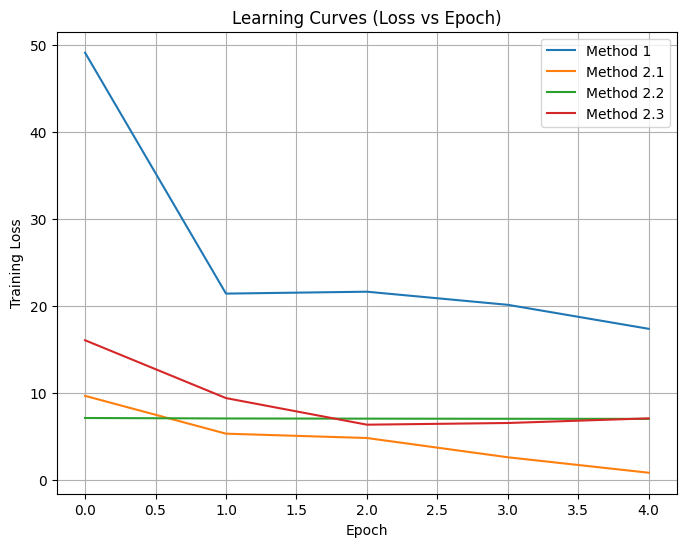

In [41]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(model, query_set):
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for image, label in query_set:
            image = image.unsqueeze(0).to(device)
            label = torch.tensor([label]).to(device)

            output = model(image)
            pred = torch.argmax(output, dim=1)

            all_preds.append(pred.item())
            all_labels.append(label.item())

    return {
        "Accuracy": accuracy_score(all_labels, all_preds),
        "Precision": precision_score(all_labels, all_preds, zero_division=0),
        "Recall": recall_score(all_labels, all_preds, zero_division=0),
        "F1-score": f1_score(all_labels, all_preds, zero_division=0)
    }

results = {}

results["Method 1 (Task A from scratch)"] = evaluate_model(model_A, query_A)
results["Method 2.1 (Random init + Support A)"] = evaluate_model(model_A_support, query_A)
results["Method 2.2 (Task A → Task B)"] = evaluate_model(model_B, query_B)
results["Method 2.3 (10-class → Task A)"] = evaluate_model(model_A_ft, query_A)

results_df = pd.DataFrame(results).T
print("\n=== Query Set Performance Comparison ===\n")
print(results_df)

plt.figure(figsize=(8,6))

plt.plot(loss_method1, label="Method 1")
plt.plot(loss_method2_1, label="Method 2.1")
plt.plot(loss_method2_2, label="Method 2.2")
plt.plot(loss_method2_3, label="Method 2.3")

plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Learning Curves (Loss vs Epoch)")
plt.legend()
plt.grid(True)
plt.show()


Some Theoritical Questions :

1.   Which strategy in Method 2 works best and why do you feel so ?
2.   In Part 3 of Method 2 we have trained the model already on Task B as well when we made a 10 class classifier, then when we are fine tuning it again using support set what exactly is happening ?
3.   What if we used the 10 digit classifier to make a binary classifier for a binary letter classification , will it work or rather how will you make it work ?
4.   Where exactly have we used Meta Learning, in which approach? Have we even used it ?

---


Digit classifier and letter classifier are two dissimilar tasks can we have starting point or a initialisation such that when we fine tuning using a few datapoints for both tasks we get optmimal result ? This is what we will try to do in MAML ?


---


Think on them sincerely , would love to read your answers!



Method 2.3 (training on all 10 digits and then fine-tuning on the support set) works best.
This is because the model learns general features such as edges, curves, and stroke patterns from all digits during the 10-class training phase. When it is later fine-tuned on a specific binary task using a small support set, only the final decision boundary needs to be adjusted. As a result, the model adapts quickly and achieves better performance with very few samples.
During 10-class training, the model learns to distinguish all digits simultaneously, but it does not specialize in any particular binary task. During fine-tuning, the objective changes: the model is now trained to focus only on separating two specific classes. Fine-tuning refines the learned features and sharpens the decision boundary for the selected task, even though the model has seen those digits before.
A digit classifier will not directly work for letter classification because digits and letters are different high-level concepts. However, it can be made to work through transfer learning. The convolutional layers, which learn low-level features such as edges and strokes, can be reused. The final classification layers should be replaced, and the model should be fine-tuned using letter data. This allows the model to adapt its learned representations to the new task.
We have not used true meta-learning in any of the approaches. The methods implemented involve pretraining, transfer learning, and fine-tuning, but the model is not explicitly trained to learn new tasks quickly. Meta-learning requires optimizing the model so that it can rapidly adapt to unseen tasks, which was not done here.
Yes, it is possible to learn an initialization that adapts well to different tasks using only a few data points, and this is exactly what MAML aims to achieve. MAML learns a set of initial parameters such that a small number of gradient updates can produce good performance on a wide range of tasks. This allows fast adaptation to both digit and letter classification tasks despite their differences.

# ALL THE BEST !